In [2]:
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mp
import statsmodels.api as sm

/home/diogro/projects/NEX-HS_C-GxE/graphtool/.venv/lib/python3.9/site-packages/graph_tool/draw/cairo_draw.py:1501: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [4]:
    gene_expr = pd.read_table("../data/RawCounts_CPM1_head_hsctrl_onlyGEMMAsamples_Mar21.21.txt")

In [5]:
gene_expr

,106_B2,106_B7,106_B9,106_C12,106_A10,106_C4,106_C6,106_C7,106_D11,106_D2,...,98_F5,98_F9,98_G12,98_G5,98_G6,98_G8,98_H11,98_H12,98_H4,98_H5
FBgn0031081,205,172,94,102,184,203,263,12,102,187,...,268,83,107,28,117,271,93,55,18,87
FBgn0031080,38,23,22,6,50,27,53,12,17,45,...,97,10,34,44,14,74,24,12,9,18
FBgn0053217,16,42,1,13,6,33,11,3,0,3,...,19,11,0,0,8,10,5,0,0,0
FBgn0052350,55,245,65,40,78,73,73,0,27,60,...,79,22,25,58,14,100,18,8,8,11
FBgn0024733,9380,20977,5244,4331,5731,11636,19831,483,6205,6918,...,24742,8670,8070,2746,4459,15867,3568,1512,3069,5130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FBgn0031309,25,66,9,6,18,16,44,3,8,9,...,24,23,6,7,0,3,3,12,10,16
FBgn0031305,91,99,46,74,78,126,125,2,64,79,...,410,67,107,6,30,124,77,18,42,40
FBgn0016926,1131,1006,944,592,1230,2007,2325,221,892,956,...,1528,370,1065,773,506,1481,294,305,219,117
FBgn0031299,6,10,36,6,25,16,3,25,4,2,...,4,10,0,0,10,4,5,0,0,0


In [6]:
### Input covariates

covariates = pd.read_table("../data/GXEpaper/Covariates_forGEMMA_Jan82021.txt", sep = ",")
ID_C = covariates.query('treatment == 1')["ID"]
ID_HS = covariates.query('treatment == 1')["ID"]

### Separating gene expressions
gene_expr_dict = {"C": gene_expr[ID_C].T, "HS": gene_expr[ID_HS].T}

In [9]:
max_row = gene_expr_dict["C"].max(axis=1)

In [11]:
sum_row = gene_expr_dict["C"].sum(axis=1)

In [198]:
g = Graph(directed=False)
n_genes = 100 #gene_expr_corr["C"].shape[1]
n_samples = 100
g.add_vertex(n = n_genes)
g.add_vertex(n = n_samples)
g.vertex_properties["isGene"] = g.new_vp("bool", True)

In [199]:
isGene = g.vertex_properties["isGene"]
for v in g.vertices():
    if(v > n_genes):
        isGene[v] = False

In [203]:
n = g.new_ep("int", 0)   # number of measurements
x = g.new_ep("int", 0)   # number of observations
ew = g.new_ep("int", val=0) # a propriedade zen de ser o nada
array_expr = np.array(gene_expr_dict["C"])
for i in range(n_samples):
    for j in range(n_genes):
        g.add_edge(i + n_genes, j)
        e = g.edge(i + n_genes, j)
        x[e] = array_expr[i][j]
        n[e] = sum_row[j]


In [201]:
n_0 = sum_row.median().astype(int)
x_0 = 0 #array_expr[1:n_samples, 1:n_genes].median().astype(int)

In [204]:
state = MixedMeasuredBlockState(g, n=n, n_default=n_0, x=x, x_default=x_0, state_args=dict(eweight=ew))
mcmc_equilibrate(state, wait=200, mcmc_args=dict(niter=10))

(34969959.31247448, 15030299, 3532885)

In [205]:
u = None              # marginal posterior edge probabilities
bs = []               # partitions
cs = []               # average local clustering coefficient

def collect_marginals(s):
   global u, bs, cs
   u = s.collect_marginal(u)
   bstate = s.get_block_state()
   bs.append(bstate.levels[0].b.a.copy())
   cs.append(local_clustering(s.get_graph()).fa.mean())

mcmc_equilibrate(state, force_niter=2000, mcmc_args=dict(niter=10),
                 callback=collect_marginals)

(35090416.411092326, 24481260, 5707195)

<AxesSubplot:>

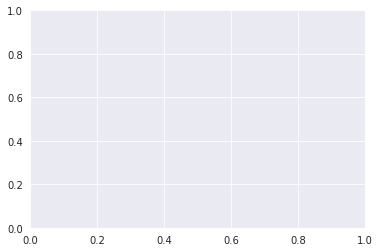

In [195]:
import seaborn as sns

sns.set_style('darkgrid')
sns.histplot(u.ep.eprob.fa)

In [197]:
u.ep.eprob.fa

PropertyArray([], dtype=float64)

In [156]:
u = GraphView(u, efilt=u.ep.eprob.fa > .5)


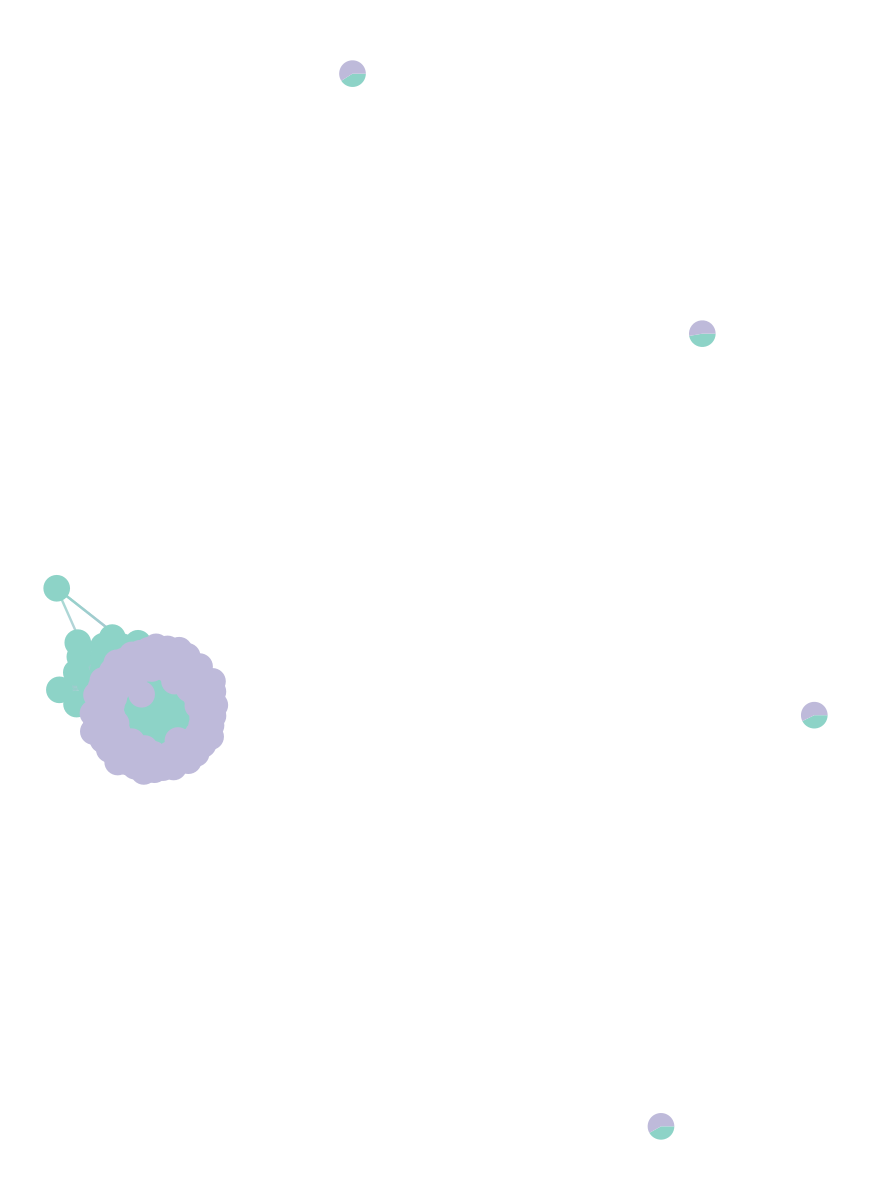

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f84d50f3400, at 0x7f84d50faee0>

In [157]:
bstate = state.get_block_state()
bstate = bstate.levels[0].copy(g=u)

# Disambiguate partitions and obtain marginals
pmode = PartitionModeState(bs, converge=True)
pv = pmode.get_marginal(u)

bstate.draw(vertex_shape="pie", vertex_pie_fractions=pv)